# To Understand Gradcam working and implementing it.

Different ways of visualizing what netowrk is learning are- Gradcam, cam, Deconvnet.

##**Import Libraries and modules**

# GRADCAM

Let's start with a pretrained VGG model, and other functions required to preprocess image.

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

##Load Model and image, and preprocess image.

1.  Loading helper functions
2.  Load VGG Model
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [0]:
model = VGG16(weights="imagenet")
from skimage import io
dog = io.imread("https://www.rspcansw.org.au/wp-content/uploads/2019/04/bullbreed1.jpg")
dog = cv2.resize(dog, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(dog)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

From model.summary() we can infer that block4_conv3 , block4_conv3 are l, l-1 layer correspondingly.

In [36]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Lets define Gradcam function

Steps for gradcam-
1. We get the predictions for the image
2. We take the topmost class index
3. Take output from the final convolutional layer.
4. Compute the gradient of the class output value with respect to the feature map
5. Pool the gradients over all the axies leaving out the channel dimension
6. Weigh the output feature map with the computed gradient values.
7. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14 
8. Normalize the heat map to make the values between 0 and 1

In [0]:
from keras import backend as K
def gradcam(processed_image, model,input_image, layer_name,class_id = None):
  preds = model.predict(x)
  if not class_id:
    class_idx = np.argmax(preds[0])
  else :
    class_idx=class_id
  print(class_idx)
  class_output = model.output[:, class_idx]
  #print(class_output)
  last_conv_layer = model.get_layer(layer_name)
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  print(grads.shape)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  print(pooled_grads.shape)
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis = -1)
  print(conv_layer_output_value.shape)
  print(heatmap.shape)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (input_image.shape[1], input_image.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(input_image, 0.5, heatmap, 0.5, 0)
  from google.colab.patches import cv2_imshow
  cv2_imshow( input_image)
  cv2_imshow(superimposed_img)

##Showing  gradcam results for last 3 years. block5_conv3, block5_conv2, block5_conv1.

**Summary :-**


*   The Gradcam/heatmap for last layer block5_conv3 is concentrated to a very specific region identifying dog class by looking at face of dog.
*   For layer block5_conv1 which is 2 layers before last layer heatmap is spread across dog image. trying to learn from generalised features.




180
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


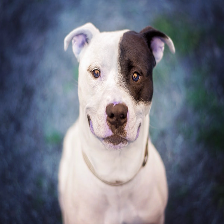

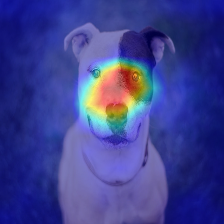

In [49]:
 gradcam(x, model,dog, 'block5_conv3',class_id = None)

180
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


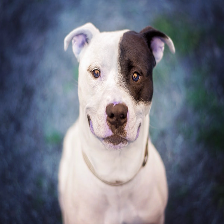

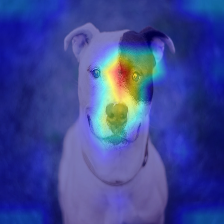

In [48]:
gradcam(x, model,dog, 'block5_conv2',class_id = None)

180
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


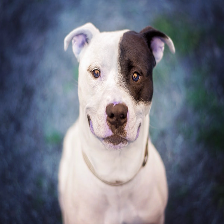

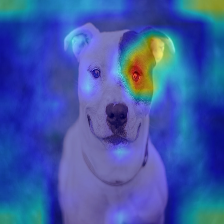

In [47]:
gradcam(x, model,dog, 'block5_conv1',class_id = None)

##Second part of assignment 
1. Load this image  (https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg)
2. "Find"  "sunglasses" in the image using GradCAM

Load image, preprocess it before calling gradcam function

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


(1, 224, 224, 3)


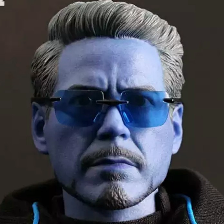

In [75]:
sunglass = io.imread("/content/drive/My Drive/sunglass.jpg")
sunglass = cv2.resize(sunglass, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(sunglass)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(x.shape)
cv2_imshow(sunglass)


In [0]:
y_prob = model.predict(x) 
y_classes = y_prob.argmax(axis=-1)
label = decode_predictions(y_prob) 

In [77]:
label

[[('n04356056', 'sunglasses', 0.3326374),
  ('n04355933', 'sunglass', 0.26927033),
  ('n04162706', 'seat_belt', 0.042314082),
  ('n03995372', 'power_drill', 0.035526622),
  ('n03763968', 'military_uniform', 0.018305518)]]

In [78]:
y_classes

array([837])

**To get classid for sunglasses class**
Vgg16 model is trained on imagenet dataset for 1000 classes.
After referncing the links [quoralink](https://www.quora.com/What-are-the-categories-that-VGG16-caffe-model-can-detect),

[imagenetclass list](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

For sunglasses possible classids are -

836: 'sunglass',

837: 'sunglasses, dark glasses, shades',



836
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


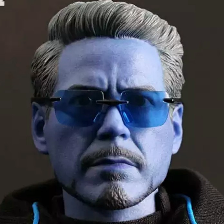

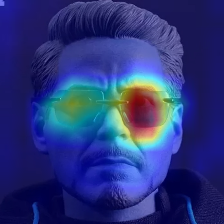

In [81]:
gradcam(x, model,sunglass, 'block5_conv3',class_id = 836)

837
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


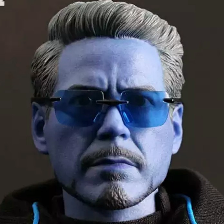

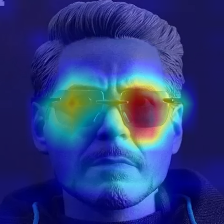

In [82]:
gradcam(x, model,sunglass, 'block5_conv3',class_id = 837)